In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.optim import Adam, ClippedAdam

from datetime import datetime
import json
from collections import defaultdict
import itertools

import os

from prod_slda.model import ProdSLDA
from prod_slda.data_utils import *

In [2]:
def set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [3]:
# ----- EXPERIMENT HPARAMS -----
META_FEATURES   = ['pos_bigrams','formality','emoji_task', 'casing','punc_tags', 'sentiment_task']
EXPERIMENT_NAME = '_'.join(META_FEATURES)

# ----- DATA HPARAMS -----
OUT_DIR       = '/mnt/swordfish-pool2/ndeas/prob_models/results2/' #'/burg/nlp/users/zfh2000/style_results'

DATA_SRC      = '/mnt/swordfish-pool2/ndeas/prob_models/data/enron_processed.json' #'/burg/nlp/users/zfh2000/enron_processed.json'
SPLITS_PATH   = '/mnt/swordfish-pool2/ndeas/prob_models/data/authors_splits.json' #'/burg/home/zfh2000/styletopicmodeling/scripts/authors_splits.json'
SYNTHETIC_SRC = '/mnt/swordfish-pool2/ndeas/prob_models/data/gpt_4_enron_processed.json' #'/burg/nlp/users/zfh2000/gpt_4_enron_processed.json'

BATCH_SIZE  = 128
NUM_WORKERS = 2

MAX_DF = 0.8
MIN_DF = 20

NUM_EPOCHS = 30

DEVICE = torch.device('cuda:0')

DATA_DIR_PATH = os.path.join(OUT_DIR,EXPERIMENT_NAME, f'maxdf{MAX_DF}_mindf{MIN_DF}_DATA')

# Data Setup 

## Data Preprocessing/Loading

In [4]:
if not os.path.exists(DATA_DIR_PATH):
    bows, meta_vectorized, vectorizer, raw_text, authors_json, meta_features_to_names = prepare_data(DATA_SRC,
                 SYNTHETIC_SRC,
                 SPLITS_PATH,
                 META_FEATURES,
                 DATA_DIR_PATH,
                 max_df = MAX_DF,
                 min_df = MIN_DF)
else:
    print(f"LOADING FROM {DATA_DIR_PATH}")
    
    bows, meta_vectorized, vectorizer, raw_text, authors_json, meta_features_to_names = load_data(DATA_DIR_PATH)   

LOADING FROM /mnt/swordfish-pool2/ndeas/prob_models/results2/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/maxdf0.8_mindf20_DATA


In [5]:
NUM_DOCS   = bows['training'].shape[0]
VOCAB_SIZE = bows['training'].shape[1]
META_SIZE  = {k:v.shape[1] for k,v in meta_vectorized['training'].items()}
IDX_TO_TERM = {v:k for k,v in vectorizer.vocabulary_.items()}

In [6]:
print(f'BOW Dims: {bows["training"].shape}')
print(f'META Dims: {META_SIZE}')

BOW Dims: (66668, 3098)
META Dims: {'casing': 3, 'emoji_task': 20, 'formality': 2, 'pos_bigrams': 324, 'punc_tags': 20, 'sentiment_task': 3}


## Dataset

In [7]:
dataset = DocMetaData(bows['training'], meta_vectorized['training'])
eval_dataset = DocMetaData(bows['holdout'], meta_vectorized['holdout'], split_halves = True)

In [8]:
dl = DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle=True)
eval_dl = DataLoader(eval_dataset, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle=True)

In [9]:
train_test_batch = next(iter(dl))
for k, v in train_test_batch.items():
    if isinstance(v, dict):
        print(k)
        for k1, v1 in v.items():
             print(f'\t{k1:15s}: {str(v1.shape)}')
    else:
        print(f'{k:15s}\n\t{"":15s}: {v.shape}')

bow            
	               : torch.Size([128, 3098])
meta
	casing         : torch.Size([128, 3])
	emoji_task     : torch.Size([128, 20])
	formality      : torch.Size([128, 2])
	pos_bigrams    : torch.Size([128, 324])
	punc_tags      : torch.Size([128, 20])
	sentiment_task : torch.Size([128, 3])


In [10]:
eval_test_batch = next(iter(eval_dl))
for k, v in eval_test_batch.items():
    if isinstance(v, dict):
        print(k)
        for k1, v1 in v.items():
             print(f'\t{k1:15s}: {str(v1.shape)}')
    else:
        print(f'{k:15s}\n\t{"":15s}: {v.shape}')

bow            
	               : torch.Size([128, 3098])
meta
	casing         : torch.Size([128, 3])
	emoji_task     : torch.Size([128, 20])
	formality      : torch.Size([128, 2])
	pos_bigrams    : torch.Size([128, 324])
	punc_tags      : torch.Size([128, 20])
	sentiment_task : torch.Size([128, 3])
bow_h1         
	               : torch.Size([128, 3098])
bow_h2         
	               : torch.Size([128, 3098])


# Training

In [21]:
# ----- TRAINING HPARAMS -----

LRS = [1e3, 1e2, 1e1]
BETAS = (0.99, 0.999)
EPS   = 1e-8
CLIP_NORM = 10.
# ADAM_ARGS = {'lr': LR, 'betas': BETAS, 'eps': EPS, 'clip_norm': CLIP_NORM}

# ----- MODEL HPARAMS -----

NUM_TOPICS = 10
NUM_STYLES = 10
HIDDEN_DIM = 128
DROPOUT    = 0

THETA_PRIOR_DIST = 'gaussian'
THETA_PRIOR_LOC = 0.
THETA_PRIOR_SCALES = [1., 3., 5.]

KAPPA_PRIOR_DISTS = ['gaussian']
KAPPA_PRIOR_LOC = 0.
KAPPA_PRIOR_SCALES = [1., 3., 5.]

STYLE_TOPIC_LINK = 'kappa_doc'

HPARAM_QUART = 0

In [22]:
hparam_combos = itertools.product(LRS, THETA_PRIOR_SCALES, KAPPA_PRIOR_DISTS, KAPPA_PRIOR_SCALES)
hparam_combos = [dict(zip(['lr', 'theta_prior_scale', 'kappa_prior_dist', 'kappa_prior_scale'], list(hparam_combo))) for hparam_combo in hparam_combos]

In [23]:
hp_start = HPARAM_QUART * (len(hparam_combos)//4 + 1)
hp_end   = (HPARAM_QUART + 1) * (len(hparam_combos)//4 + 1)
hparam_combos = hparam_combos[hp_start:hp_end]

# Tuning 

In [29]:
def train_epochs(prod_slda, svi, train_dl, eval_dl, num_epochs, device, last_elbos = 5):
    total_epochs = 0
    train_elbo = []
    val_elbo = []

    print("---TRAINING---")
    for epoch in range(num_epochs):

        epoch_elbo = 0.
        prod_slda.train()
        for batch in tqdm(train_dl):

            batch = batch_to_device(batch, device)

            bow = batch['bow']
            meta = batch['meta']

            epoch_elbo += svi.step(bow, meta)


        eval_elbo = 0
        prod_slda.eval()
        with torch.no_grad():
            for batch in tqdm(eval_dl):

                batch = batch_to_device(batch, device)

                bow = batch['bow']
                meta = batch['meta']

                eval_elbo += svi.evaluate_loss(bow, meta)           


        print(f'Epoch {epoch}: {epoch_elbo:.3f}')
        print(f'Epoch {epoch}: Eval: {eval_elbo:.3f}')

        train_elbo.append(epoch_elbo)
        val_elbo.append(eval_elbo)
        total_epochs +=1

        if len(val_elbo) > last_elbos:
            val_elbo_changes = [val_elbo[i] - val_elbo[i-1] for i in range(len(val_elbo) - last_elbos, len(val_elbo))]
            if np.mean(val_elbo_changes) > 0:
                print('Val ELBO diverging, stopping fitting')
                break
                
    return train_elbo, val_elbo, total_epochs

In [30]:
def plot_elbos(train_elbo, val_elbo, path):
    plt.plot(range(len(train_elbo)), [e/len(dl.dataset) for e in train_elbo], label = 'In-Sample')
    plt.plot(range(len(val_elbo)), [e/len(eval_dl.dataset) for e in val_elbo], label = 'Out-Sample')

    plt.legend()
    plt.xlabel('# Iterations')
    plt.ylabel('ELBO')

    plt.savefig(os.path.join(path, 'loss_plot_indep.png'), dpi = 500, facecolor = None)

In [26]:
base_info = {
    'experiment_name': EXPERIMENT_NAME,
    'num_topics': NUM_TOPICS,
    'num_styles': NUM_STYLES,
    'hidden_dim': HIDDEN_DIM,
    'dropout': DROPOUT,
    'theta_prior_dist': THETA_PRIOR_DIST,
    'theta_prior_loc': THETA_PRIOR_LOC,
    'kappa_prior_loc': KAPPA_PRIOR_LOC,
    'style_topic_link': STYLE_TOPIC_LINK,
    'num_epochs': NUM_EPOCHS,
    'betas': BETAS,
    'eps': EPS,
    'batch_size': BATCH_SIZE,
    'clip_norm': CLIP_NORM,
    'num_workers': NUM_WORKERS,
    'device': DEVICE.type,
    'meta_features': META_FEATURES,
    'DATA_SRC': DATA_SRC,
    'SPLITS_PATH': SPLITS_PATH,
    'SYNTHETIC_SRC': SYNTHETIC_SRC,
    'MAX_DF': MAX_DF,
    'MIN_DF': MIN_DF,
}

LAST_ELBOS = 5

In [ ]:
for hparam in hparam_combos:
    
    # Create and save configuration info
    date = datetime.now().strftime("%Y-%m-%d_%H_%M_%S")

    info = dict(hparam, **base_info)
    info['date'] = date
    
    PATH = os.path.join(OUT_DIR, EXPERIMENT_NAME, date)
    os.makedirs(PATH, exist_ok=True)
    with open(os.path.join(PATH, 'info.json'), 'w') as f:
        json.dump(info, f, indent=4)
        
    # Create Model
    prod_slda = ProdSLDA(
        vocab_size = VOCAB_SIZE,
        meta_sizes  = META_SIZE,
        num_topics = NUM_TOPICS, num_styles = NUM_STYLES, 
        hidden = HIDDEN_DIM, dropout = DROPOUT, 
        theta_prior_dist = THETA_PRIOR_DIST, 
        theta_prior_loc = THETA_PRIOR_LOC, theta_prior_scale = info['theta_prior_scale'],
        kappa_prior_dist = info['kappa_prior_dist'], 
        kappa_prior_loc = KAPPA_PRIOR_LOC, kappa_prior_scale = info['kappa_prior_scale'],
        style_topic_link = STYLE_TOPIC_LINK,
    ).to(DEVICE)
    
    # Setup Fitting
    pyro.clear_param_store()
    prod_slda.train()
    
    adam_args = {'lr': info['lr'], 'betas': BETAS, 'eps': EPS, 'clip_norm': CLIP_NORM}
    
    optim = pyro.optim.ClippedAdam(adam_args)

    svi = SVI(
        pyro.poutine.scale(prod_slda.model, BATCH_SIZE/len(dl.dataset)),
        pyro.poutine.scale(prod_slda.guide, BATCH_SIZE/len(dl.dataset)),
        optim,
        loss = TraceMeanField_ELBO()
    )
    
    train_elbo, val_elbo, total_epochs = train_epochs(prod_slda, svi, 
                                        dl, eval_dl, 
                                        NUM_EPOCHS, DEVICE,
                                        last_elbos = LAST_ELBOS)
    
    # Save recorded elbos
    elbos = pd.DataFrame({'train_elbo': train_elbo, 'val_elbo': val_elbo})
    elbos.to_csv(os.path.join(PATH, 'elbos.json'), index = False)
    
    # Save convergence plot
    plot_elbos(train_elbo, val_elbo, PATH)
    
    # Save final model
    path = os.path.join(PATH, f'model_epoch{total_epochs}_{val_elbo[-1]}.pt')
    prod_slda.eval()
    torch.save(prod_slda, path)
    print(f'Model saved to {path}')
    
    

---TRAINING---


100%|██████████| 179/179 [00:12<00:00, 13.96it/s]


Epoch 0: 20035.862
Epoch 0: Eval: 6138.221


100%|██████████| 179/179 [00:12<00:00, 14.55it/s]


Epoch 1: 19454.277
Epoch 1: Eval: 6195.405


100%|██████████| 179/179 [00:12<00:00, 14.66it/s]


Epoch 2: 18643.537
Epoch 2: Eval: 5947.696


100%|██████████| 179/179 [00:12<00:00, 14.57it/s]


Epoch 3: 18198.238
Epoch 3: Eval: 5950.411


100%|██████████| 179/179 [00:12<00:00, 14.43it/s]


Epoch 4: 17831.517
Epoch 4: Eval: 5846.821


100%|██████████| 179/179 [00:12<00:00, 14.32it/s]


Epoch 5: 17587.281
Epoch 5: Eval: 5845.798


100%|██████████| 179/179 [00:12<00:00, 14.52it/s]


Epoch 6: 17355.029
Epoch 6: Eval: 5731.768


100%|██████████| 179/179 [00:11<00:00, 15.06it/s]


Epoch 7: 17161.307
Epoch 7: Eval: 5630.562


100%|██████████| 179/179 [00:12<00:00, 14.83it/s]


Epoch 8: 16990.427
Epoch 8: Eval: 5616.791


100%|██████████| 179/179 [00:12<00:00, 14.38it/s]


Epoch 9: 16818.769
Epoch 9: Eval: 5547.006


100%|██████████| 179/179 [00:12<00:00, 14.76it/s]


Epoch 10: 16637.752
Epoch 10: Eval: 5511.216


100%|██████████| 179/179 [00:12<00:00, 14.71it/s]


Epoch 11: 16518.299
Epoch 11: Eval: 5528.705


100%|██████████| 179/179 [00:11<00:00, 14.99it/s]


Epoch 12: 16422.514
Epoch 12: Eval: 5547.645


100%|██████████| 179/179 [00:12<00:00, 14.43it/s]


Epoch 13: 16277.072
Epoch 13: Eval: 5529.783


100%|██████████| 179/179 [00:12<00:00, 14.09it/s]


Epoch 14: 16109.609
Epoch 14: Eval: 5496.525


100%|██████████| 179/179 [00:11<00:00, 15.03it/s]


Epoch 15: 15969.330
Epoch 15: Eval: 5497.565


100%|██████████| 179/179 [00:12<00:00, 14.83it/s]


Epoch 16: 15944.301
Epoch 16: Eval: 5505.481


100%|██████████| 179/179 [00:12<00:00, 14.44it/s]


Epoch 17: 15827.541
Epoch 17: Eval: 5394.678


100%|██████████| 179/179 [00:12<00:00, 14.40it/s]


Epoch 18: 15660.642
Epoch 18: Eval: 5411.556


100%|██████████| 179/179 [00:12<00:00, 14.37it/s]


Epoch 19: 15531.921
Epoch 19: Eval: 5363.134


100%|██████████| 179/179 [00:11<00:00, 14.93it/s]


Epoch 20: 15378.330
Epoch 20: Eval: 5408.408


100%|██████████| 179/179 [00:12<00:00, 14.42it/s]


Epoch 21: 15318.415
Epoch 21: Eval: 5362.539


100%|██████████| 179/179 [00:12<00:00, 14.44it/s]


Epoch 22: 15240.853
Epoch 22: Eval: 5408.175
Val ELBO diverging, stopping fitting
Model saved to /mnt/swordfish-pool2/ndeas/prob_models/results2/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/2023-12-20_14_33_36/model_epoch23_5408.175060272217.pt
---TRAINING---


100%|██████████| 179/179 [00:12<00:00, 14.45it/s]


Epoch 0: 19763.057
Epoch 0: Eval: 6387.022


100%|██████████| 179/179 [00:12<00:00, 14.40it/s]


Epoch 1: 19455.408
Epoch 1: Eval: 6299.666


100%|██████████| 179/179 [00:12<00:00, 14.38it/s]


Epoch 2: 18987.836
Epoch 2: Eval: 6212.140


100%|██████████| 179/179 [00:11<00:00, 14.95it/s]


Epoch 3: 18599.827
Epoch 3: Eval: 6132.001


100%|██████████| 179/179 [00:12<00:00, 14.63it/s]


Epoch 4: 18165.441
Epoch 4: Eval: 6020.107


100%|██████████| 179/179 [00:12<00:00, 14.50it/s]


Epoch 5: 17868.311
Epoch 5: Eval: 5931.089


100%|██████████| 179/179 [00:11<00:00, 15.45it/s]


Epoch 6: 17547.083
Epoch 6: Eval: 5878.962


100%|██████████| 179/179 [00:12<00:00, 14.36it/s]


Epoch 7: 17285.544
Epoch 7: Eval: 5792.694


100%|██████████| 179/179 [00:12<00:00, 14.51it/s]


Epoch 8: 17042.814
Epoch 8: Eval: 5764.965


100%|██████████| 179/179 [00:11<00:00, 14.99it/s]


Epoch 9: 16840.900
Epoch 9: Eval: 5666.802


100%|██████████| 179/179 [00:12<00:00, 14.72it/s]


Epoch 10: 16641.093
Epoch 10: Eval: 5584.883


100%|██████████| 179/179 [00:11<00:00, 15.09it/s]


Epoch 11: 16445.471
Epoch 11: Eval: 5551.457


100%|██████████| 179/179 [00:12<00:00, 14.42it/s]


Epoch 12: 16267.616
Epoch 12: Eval: 5522.744


100%|██████████| 179/179 [00:12<00:00, 14.80it/s]


Epoch 13: 16088.024
Epoch 13: Eval: 5429.382


100%|██████████| 179/179 [00:12<00:00, 14.12it/s]


Epoch 14: 15913.298
Epoch 14: Eval: 5384.471


100%|██████████| 179/179 [00:12<00:00, 14.63it/s]


Epoch 15: 15759.604
Epoch 15: Eval: 5344.384


100%|██████████| 179/179 [00:12<00:00, 14.57it/s]


Epoch 16: 15616.811
Epoch 16: Eval: 5286.763


100%|██████████| 179/179 [00:12<00:00, 14.83it/s]


Epoch 17: 15485.281
Epoch 17: Eval: 5265.129


100%|██████████| 179/179 [00:12<00:00, 14.47it/s]


Epoch 18: 15428.418
Epoch 18: Eval: 5225.478


100%|██████████| 179/179 [00:12<00:00, 14.19it/s]


Epoch 19: 15382.899
Epoch 19: Eval: 5184.446


100%|██████████| 179/179 [00:12<00:00, 14.50it/s]


Epoch 20: 15208.637
Epoch 20: Eval: 5167.148


100%|██████████| 179/179 [00:12<00:00, 14.76it/s]


Epoch 21: 15128.226
Epoch 21: Eval: 5119.321


 96%|█████████▌| 499/521 [00:27<00:01, 16.72it/s]

## Setup

In [139]:
prod_slda = ProdSLDA(
    vocab_size = VOCAB_SIZE,
    meta_sizes  = META_SIZE,
    num_topics = NUM_TOPICS, num_styles = NUM_STYLES, 
    hidden = HIDDEN_DIM, dropout = DROPOUT, 
    theta_prior_dist = THETA_PRIOR_DIST, 
    theta_prior_loc = THETA_PRIOR_LOC, theta_prior_scale = THETA_PRIOR_SCALE,
    kappa_prior_dist = KAPPA_PRIOR_DIST, 
    kappa_prior_loc = KAPPA_PRIOR_LOC, kappa_prior_scale = KAPPA_PRIOR_SCALE,
    style_topic_link = STYLE_TOPIC_LINK,
).to(DEVICE)

print(prod_slda.beta_document())
print(prod_slda.beta_meta())


{'beta_topic': tensor([[-0.1861, -0.2402, -0.0274,  ...,  0.2100, -0.2068,  0.1123],
        [ 0.2663, -0.2054, -0.0130,  ..., -0.0374,  0.1646,  0.0540],
        [-0.3140,  0.2888,  0.1739,  ..., -0.2029, -0.1254,  0.2051],
        ...,
        [-0.0689, -0.0193,  0.0797,  ...,  0.3000,  0.0952,  0.1868],
        [-0.0405,  0.2724, -0.2607,  ..., -0.1828, -0.2136, -0.0969],
        [ 0.0648, -0.0951, -0.0693,  ..., -0.0947,  0.2504,  0.1516]]), 'beta_style': tensor([[-0.1226,  0.0980,  0.0822,  ...,  0.2889,  0.2423,  0.2072],
        [-0.1276,  0.0839,  0.0380,  ..., -0.1525,  0.1558, -0.0565],
        [-0.2923, -0.2537,  0.1500,  ...,  0.2557, -0.1137, -0.1439],
        ...,
        [-0.2687,  0.2041,  0.0681,  ...,  0.1140, -0.2495,  0.2273],
        [ 0.2871,  0.1236,  0.2097,  ...,  0.2350, -0.0243,  0.0878],
        [-0.1396, -0.0803, -0.0072,  ...,  0.0168, -0.3042, -0.1147]])}
{'casing': tensor([[-0.1345,  0.0874,  0.2322],
        [ 0.2797,  0.0799,  0.0315],
        [ 0.3098

## Training 

In [140]:
%%capture cap --no-stderr
pyro.clear_param_store()
prod_slda.train()

In [141]:
optim = pyro.optim.ClippedAdam(ADAM_ARGS)

svi = SVI(
    pyro.poutine.scale(prod_slda.model, BATCH_SIZE/len(dl.dataset)),
    pyro.poutine.scale(prod_slda.guide, BATCH_SIZE/len(dl.dataset)),
    optim,
    loss = TraceMeanField_ELBO()
)

In [142]:
total_epochs = 0

In [143]:
train_elbo = []
val_elbo = []

print("---TRAINING---")
for epoch in range(NUM_EPOCHS):
    
    epoch_elbo = 0.
    prod_slda.train()
    for batch in tqdm(dl):
        
        batch = batch_to_device(batch, DEVICE)
        
        bow = batch['bow']
        meta = batch['meta']
        
        epoch_elbo += svi.step(bow, meta)

    eval_elbo = 0
    prod_slda.eval()
    with torch.no_grad():
        for batch in tqdm(eval_dl):
            
            batch = batch_to_device(batch, DEVICE)
            
            bow = batch['bow']
            meta = batch['meta']
    
            eval_elbo += svi.evaluate_loss(bow, meta)
    
        
    print(f'Epoch {epoch}: {epoch_elbo:.3f}')
    print(f'Epoch {epoch}: Eval: {eval_elbo:.3f}')
    
    train_elbo.append(epoch_elbo)
    val_elbo.append(eval_elbo)
    total_epochs +=1

---TRAINING---


  0%|          | 0/521 [00:00<?, ?it/s]/home/ndeas/envs/test_env/lib/python3.8/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'logtheta_s'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
  0%|          | 0/521 [00:00<?, ?it/s]


KeyError: 'logtheta_s'

In [18]:
path = os.path.join(PATH, f'model_epoch{total_epochs}_{val_elbo[-1]}.pt')
prod_slda.eval()
torch.save(prod_slda, path)
print(f'Saved to {path}')

Saved to /mnt/swordfish-pool2/ndeas/prob_models/results2/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/2023-12-20_10_20_44/model_epoch2_5944.042022705078.pt


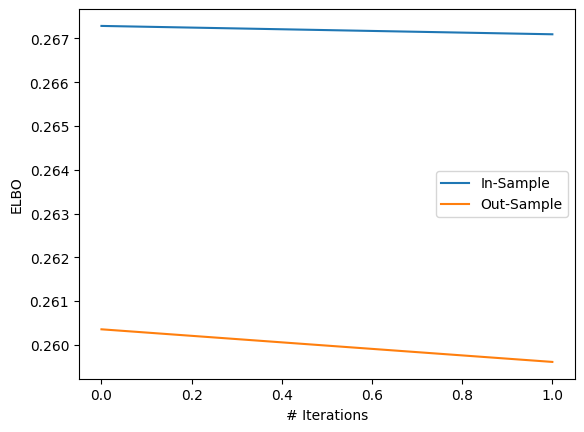

In [19]:
plt.plot(range(len(train_elbo)), [e/len(dl.dataset) for e in train_elbo], label = 'In-Sample')
plt.plot(range(len(val_elbo)), [e/len(eval_dl.dataset) for e in val_elbo], label = 'Out-Sample')

plt.legend()
plt.xlabel('# Iterations')
plt.ylabel('ELBO')

plt.savefig(os.path.join(PATH, 'loss_plot_indep.png'), dpi = 600, facecolor = None)


In [20]:
path = os.path.join(PATH, f'model_epoch{total_epochs}_{val_elbo[-1]}.pt')
prod_slda.eval()
torch.save(prod_slda, path)
print(f'Saved to {path}')

Saved to /mnt/swordfish-pool2/ndeas/prob_models/results2/pos_bigrams_formality_emoji_task_casing_punc_tags_sentiment_task/2023-12-20_10_20_44/model_epoch2_5944.042022705078.pt


# Eval 

## Reconstruct Perplexity 

In [39]:
def calc_doc_perp(prod_slda, eval_dl, device, use_style = True):
    total_ce, total_count = 0., 0.
    for batch in tqdm(eval_dl):
        for key in batch.keys():
            if isinstance(batch[key], dict):
                for key2 in batch[key].keys():
                    batch[key][key2] = batch[key][key2].to(device)
            else:
                batch[key] = batch[key].to(device)

        ce, count = prod_slda.doc_reconstruct_ce(batch, use_style = use_style)
        total_ce += ce
        total_count += count
    return torch.exp(total_ce/total_count).item()

def calc_style_perp(prod_slda, eval_dl, device):
    total_ce, total_count = 0., 0.
    for batch in tqdm(eval_dl):
        for key in batch.keys():
            if isinstance(batch[key], dict):
                for key2 in batch[key].keys():
                    batch[key][key2] = batch[key][key2].to(device)
            else:
                batch[key] = batch[key].to(device)

        ce, count = prod_slda.style_reconstruct_ce(batch)
        total_ce += ce
        total_count += count
    return torch.exp(total_ce/total_count).item()

In [36]:
prod_slda = torch.load(path).to(DEVICE)

In [40]:
doc_perp      = calc_doc_perp(prod_slda, eval_dl)
doc_only_perp = calc_doc_perp(prod_slda, eval_dl, use_style = False)
style_perp    = calc_style_perp(prod_slda, eval_dl)

100%|██████████| 179/179 [00:12<00:00, 14.10it/s]


In [41]:
print(f'Perp           : {doc_perp:.4f}')
print(f'Perp (No Style): {doc_only_perp:.4f}')
print(f'Style Perp     : {style_perp:.4f}')

Perp           : 3199.2117
Perp (No Style): 3485.7412
Style Perp     : 56.1780


# Examine Topics 

In [52]:
def top_beta_document(model, vectorizer, top_k=20):
    betas_document = model.beta_document()
    features_to_betas = {}
    idx_to_name = {v:k for k,v in vectorizer.vocabulary_.items()}
    for feature, logits in betas_document.items():
        features_to_betas[feature] = []
        num_features = logits.shape[0]
        top_results = torch.topk(logits, top_k, dim=-1)
        
        ids = top_results.indices.cpu().numpy()
        values = top_results.values.cpu().numpy()
        
        for i in tqdm(range(num_features)):
            features_to_betas[feature].append({'values':values[i], 'top':[idx_to_name[idx] for idx in ids[i]]})
                
    return features_to_betas

def top_beta_meta(model, meta_feature_to_names, top_k=20):
    betas_metas = model.beta_meta()
    features_to_betas = {}
    for feature, logits in betas_metas.items():
        idx_to_name = {i:k for i,k in enumerate(meta_feature_to_names[feature])}
        features_to_betas[feature] = []
        num_features = logits.shape[0]
        top_results = torch.topk(logits, min(top_k, logits.shape[1]), dim=-1)
        ids = top_results.indices.cpu().numpy()
        values = top_results.values.cpu().numpy()
        for i in tqdm(range(num_features)):
            features_to_betas[feature].append({'values':values[i], 'top':[idx_to_name[idx] for idx in ids[i]]})
        
    return features_to_betas 

In [53]:
top_words_per_latent = top_beta_document(prod_slda, vectorizer,  top_k=10)
top_meta_per_latent = top_beta_meta(prod_slda, meta_features_to_names, top_k=10)

print('Document Term Info')
for latent, top in top_words_per_latent.items():
    print(f'\t{latent} ({len(top)}):')
    for i, results in enumerate(top):
        print(f'\t\t {latent} ({i}):\n{results["top"]}')
        print()

print('Meta Var Info')
for latent, top in top_meta_per_latent.items():

    print(f'\t{latent} ({len(top)}):')
    for i, results in enumerate(top):
        print(f'\t\t {latent} ({i}):\n{results["top"]}')
        print()

100%|██████████| 10/10 [00:00<00:00, 118483.16it/s]

Document Term Info
	beta_topic (10):
		 beta_topic (0):
['wants', 'termination', 'general', 'caiso', 'q2', 'dial', 'ees', 'process', 'paso', 'results']

		 beta_topic (1):
['supervisor', 'contribute', 'thanx', 'addition', 'pulling', 'documents', 'years', 'brief', 'imbalance', 'gh']

		 beta_topic (2):
['mr', 'effective', 'yahoo', 'agreements', 'team', 'larry', '08', 'set', '20', 'pm']

		 beta_topic (3):
['mike', 'added', 'weekly', 'security', 'll', 'elizabeth', 'business', 'lets', 'kay', 'positions']

		 beta_topic (4):
['713', 'msn', 'delainey', 'look', 'fyi', 'robert', 'number', 'sure', 'think', 'letter']

		 beta_topic (5):
['reminder', 'jackie', 'soon', 'peak', 'theresa', 'cc', 'vacation', 'believe', 'est', 'language']

		 beta_topic (6):
['getting', 'christie', 'official', 'reports', 'pm', 'litigation', 'horton', 'unit', 'outlook', '646']

		 beta_topic (7):
['msn', '853', 'sara', 'analysis', 'fuel', 'car', 'assistance', 'latest', 'explorer', 'monday']

		 beta_topic (8):
['free'